In [1]:
import json
import time
import numpy as np
import pandas as pd
import sktime as skt
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.serialize import model_to_json, model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import *

In [2]:
df = load_data(path = '..\Binance_BTCUSDT_1h_edited.csv')
df = preprocess_df(df, 'date', scale = False)

8  values have been droped.


In [18]:
df = df.sort_index(ascending=False)
df = df.reset_index()

In [19]:
df.drop(['level_0', 'index'], axis=1,  inplace = True)
df

,date,open,high,low,close,Volume BTC,Volume USDT,tradecount,epoch
0,2020-08-01 23:00:00,11783.31,11820.61,11731.71,11801.17,2194.598589,25849742.13,37272.0,3.0
1,2020-08-02 00:00:00,11801.17,11857.00,11740.00,11782.63,2872.638184,33906617.41,47209.0,3.0
2,2020-08-02 01:00:00,11782.63,11942.55,11772.13,11942.55,3707.136801,44004705.94,55304.0,3.0
3,2020-08-02 02:00:00,11942.54,11965.01,11892.88,11928.58,3785.415559,45157950.45,51092.0,3.0
4,2020-08-02 03:00:00,11928.40,12000.00,11870.00,12000.00,3746.422743,44731714.59,59258.0,3.0
...,...,...,...,...,...,...,...,...,...
11403,2021-11-20 20:00:00,59430.04,59538.18,59308.09,59408.03,1135.464990,67455253.53,40691.0,3.0
11404,2021-11-20 21:00:00,59408.02,59650.00,59357.21,59592.71,1007.591700,59963374.76,38975.0,3.0
11405,2021-11-20 22:00:00,59592.71,59729.68,59504.95,59683.58,968.353460,57744824.37,42021.0,3.0
11406,2021-11-20 23:00:00,59683.58,59845.00,59480.86,59707.51,1275.101520,76121126.54,39388.0,3.0


In [3]:
with open('prophet_model.json', 'r') as fin:
    pf = model_from_json(json.load(fin))  # Load model

# Variables

In [17]:
# Change this
predicted_col = "day_close"
start_halving = 0
train_percentage = 1
add_regressors_to_prophet = False
shift_length = 30 # Only affects ML models
save_prediction_prophet = True # Starts predicting t=len(training_set)

In [15]:
predicted_col = "close"
start_halving = 0
train_percentage = 75
add_regressors_to_prophet = False
shift_length = 7 # Only affects ML models
save_prediction_prophet = True # Starts predicting t=len(training_set)

In [15]:
# No need to change this
assert shift_length >= 0
assert 4 >= start_halving >=0

# Preprocessing

In [3]:
df = load_data(path="../csv_combined2.csv")
df["Time"] = df["Time"].astype("datetime64")

In [9]:
df = load_data()
df.head(10)

,Time,active-addresses-btc-24h,block-height-btc-24h,block-interval-mean-btc-24h,block-interval-median-btc-24h,block-size-mean-btc-24h,block-size-total-btc-24h,blocks-mined-btc-24h,circulating-supply-btc-24h,difficulty-btc-24h,...,transfer-volume-median-btc-24h,transfer-volume-total-btc-24h,utx-os-created-btc-24h,utx-os-spent-btc-24h,utxo-value-created-mean-btc-24h,utxo-value-created-median-btc-24h,utxo-value-created-total-btc-24h,utxo-value-spent-mean-btc-24h,utxo-value-spent-median-btc-24h,utxo-value-spent-total-btc-24h
0,2010-08-17 00:00:00+00:00,365.0,74916.0,659.201550,410.0,675.527132,87143.0,129.0,3745850.0,2.198051e+12,...,50.0,49995.99,419.0,292.0,134.715967,50.0,56445.99,171.219144,50.00,49995.99
1,2010-08-18 00:00:00+00:00,595.0,75049.0,661.496241,455.0,2005.503759,266732.0,133.0,3752500.0,2.198051e+12,...,50.0,37386.94,527.0,1302.0,83.564516,49.0,44038.50,28.716206,0.01,37388.50
2,2010-08-19 00:00:00+00:00,336.0,75184.0,635.518519,429.0,623.651852,84193.0,135.0,3759250.0,2.198051e+12,...,50.0,20402.10,415.0,271.0,65.426747,50.0,27152.10,75.284502,50.00,20402.10
3,2010-08-20 00:00:00+00:00,480.0,75377.0,447.398964,288.0,595.834197,114996.0,193.0,3768900.0,2.198051e+12,...,50.0,29578.41,538.0,388.0,72.915260,50.0,39228.41,76.233015,50.00,29578.41
4,2010-08-21 00:00:00+00:00,365.0,75550.0,501.942197,356.0,539.421965,93320.0,173.0,3777550.0,2.198051e+12,...,50.0,38678.31,437.0,286.0,108.302769,50.0,47328.31,135.238846,50.00,38678.31
5,2010-08-22 00:00:00+00:00,387.0,75762.0,408.674528,287.0,472.556604,100182.0,212.0,3788150.0,2.198051e+12,...,50.0,20418.19,432.0,322.0,71.801366,50.0,31018.19,63.410528,50.00,20418.19
6,2010-08-23 00:00:00+00:00,453.0,75975.0,404.239437,265.0,488.107981,103967.0,213.0,3798800.0,2.198051e+12,...,50.0,17776.11,445.0,338.0,63.878899,50.0,28426.11,52.592041,50.00,17776.11
7,2010-08-24 00:00:00+00:00,448.0,76190.0,402.967442,298.0,836.125581,179767.0,215.0,3809550.0,2.198051e+12,...,50.0,21093.11,465.0,753.0,68.481527,50.0,31843.91,28.013161,0.01,21093.91
8,2010-08-25 00:00:00+00:00,311.0,76406.0,398.833333,254.0,415.458333,89739.0,216.0,3820350.0,2.198051e+12,...,50.0,15911.10,428.0,230.0,62.409112,50.0,26711.10,69.178696,50.00,15911.10
9,2010-08-26 00:00:00+00:00,455.0,76616.0,446.733333,274.0,562.547619,118135.0,210.0,3830850.0,2.677427e+12,...,4.9,14247.79,435.0,404.0,56.891471,50.0,24747.79,35.266807,5.00,14247.79


In [16]:
df = preprocess_df(df, start_halving=start_halving)

In [17]:
df.columns

Index(['Time', 'active-addresses-btc-24h', 'block-height-btc-24h',
       'block-interval-mean-btc-24h', 'block-interval-median-btc-24h',
       'block-size-mean-btc-24h', 'block-size-total-btc-24h',
       'blocks-mined-btc-24h', 'circulating-supply-btc-24h',
       'difficulty-btc-24h', 'ma128', 'ma14', 'ma200', 'ma25', 'ma40', 'ma60',
       'ma9', 'ma90', 'fees-mean-btc-24h', 'fees-median-btc-24h',
       'fees-total-btc-24h', 'hash-rate-btc-24h',
       'investor-capitalization-btc-24h', 'market-cap-btc-24h',
       'new-addresses-btc-24h', 'price-drawdown-from-ath-btc-24h', 'day_close',
       'day_high', 'day_low', 'day_open',
       'realized-profits-to-value-rpv-ratio-btc-24h',
       'receiving-addresses-btc-24h', 'seller-exhaustion-constant-btc-24h',
       'sending-addresses-btc-24h', 'sopr-btc-24h', 'o.daysTillHalving',
       'o.ratio', 'supply-last-active-1-years-ago-btc-24h',
       'total-addresses-btc-24h', 'transaction-count-btc-24h',
       'transaction-rate-btc-24h

# Analysis

In [20]:
# This can provide lots of functions related to rolling averages etc.
ewm = df.ewm(span=7)
ewm.mean()["close"]

0        11801.170000
1        11790.575714
2        11856.294324
3        11882.730229
4        11921.169488
             ...     
11403    58849.704226
11404    59035.455669
11405    59197.486752
11406    59324.992564
11407    59401.749423
Name: close, Length: 11408, dtype: float64

# Prediction

# Thetaforecaster
### uses simple exponential smoothing
![Formula](https://i.imgur.com/5mTIBwo.png)

### More here: https://www.youtube.com/watch?v=k_HN0wOKDd0
### Documentation: https://www.sktime.org/en/v0.4.2/modules/auto_generated/sktime.forecasting.theta.ThetaForecaster.html

In [29]:
if train_percentage == 1: # Testing testing
    forecaster = ThetaForecaster()
    forecaster.fit(df[predicted_col])
else:
    y_train, y_test = temporal_train_test_split(df[predicted_col], train_size=train_percentage)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = ThetaForecaster()
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)
    print(f"""
        Mean Absolute Scaled Error: {mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)}\n
        Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}\n
        Mean Squared Error: {mean_squared_error(y_test, y_pred)}
    """)


        Mean Absolute Scaled Error: 579.2530639447971

        Mean Absolute Error: 33225.799192991435

        Mean Squared Error: 1550178723.192759
    


# Prophet

In [30]:
addtional_variables = [] if not add_regressors_to_prophet else list(filter(lambda x: x not in ("date", predicted_col), df.columns)) 
pf_df = preprocess_for_prophet(df, extra_columns=addtional_variables)

if shift_length:
    shifted_df = pf_df[-shift_length:][addtional_variables] # Contains values dropped during shifting
    pf_df[addtional_variables] = pf_df[addtional_variables].shift(shift_length)
    pf_df = pf_df.dropna()

if train_percentage == 1:
    pf_train = pf_df
else:
    pf_train, pf_test = train_test_split(pf_df, train_size=train_percentage, shuffle=False)

pf = Prophet()
for variable in addtional_variables:
    pf.add_regressor(variable)

In [31]:
start = time.time()

pf.fit(pf_train)

end = time.time()
print(end-start)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


1.7209999561309814


In [32]:
with open('prophet_model.json', 'w') as fout:
    json.dump(model_to_json(pf), fout)  # Save model

In [33]:
if train_size != 1:
    forecast = pf.predict(pf_test)
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    pf.plot(forecast)
    pf.plot_components(forecast)
    print(f"""
        Mean Absolute Scaled Error: {mean_absolute_scaled_error(pf_test["y"], forecast["yhat"], y_train=pf_train["y"])}\n
        Mean Absolute Error: {mean_absolute_error(pf_test["y"], forecast["yhat"])}\n
        Mean Squared Error: {mean_squared_error(pf_test["y"], forecast["yhat"])}
    """)

NameError: name 'train_size' is not defined

In [26]:
if shift_length:
    shifted_df["ds"] = pf.make_future_dataframe(shift_length, include_history=False)["ds"].values
    prediction_df = pf.predict(shifted_df)
    print(prediction_df["yhat"])
    if save_prediction_prophet or True:
        prediction_df[["ds", "yhat", "yhat_lower", "yhat_upper", "trend", "trend_lower", "trend_upper"]].to_csv(\
            f"../data/results/prophet/predicted={predicted_col}_shift={shift_length}_start={prediction_df.iloc[0]['ds'].date()}_regressors={add_regressors_to_prophet}.csv", index=False)

0    11136.891799
1    11026.062189
2    10915.232580
3    10804.402970
4    10693.573361
5    10582.743751
6    10471.914141
Name: yhat, dtype: float64


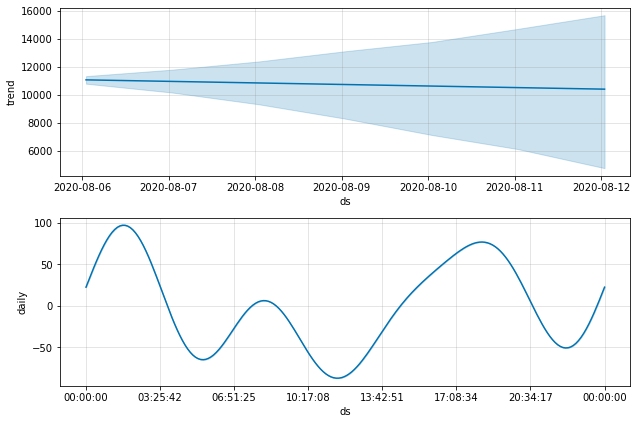

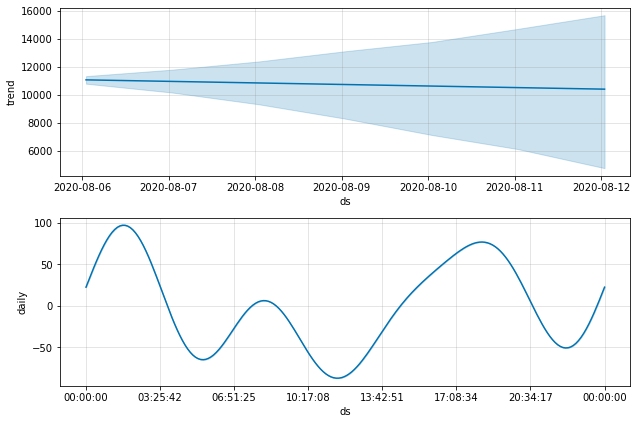

In [27]:
pf.plot_components(prediction_df)

In [27]:
df1=df.reset_index()['close']

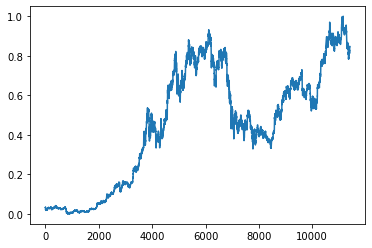

In [29]:
plt.plot(df1)

In [30]:
print(df1)

0        0.031609
1        0.031293
2        0.034018
3        0.033780
4        0.034997
           ...   
11403    0.842800
11404    0.845947
11405    0.847496
11406    0.847903
11407    0.846617
Name: close, Length: 11408, dtype: float64


In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [32]:
training_size=int(len(df1)*0.90)
test_size=len(df1)-training_size
train_data , test_data =df1 [0:training_size,:] , df1[training_size:len(df1),:1]

In [33]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 24
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [35]:
print(X_train.shape), print(y_train.shape)

(10242, 24)
(10242,)


(None, None)

In [36]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [41]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(24,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 24, 50)            10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=2000,batch_size=32,verbose=1)

Epoch 1/2000
321/321 [==============================] - 8s 15ms/step - loss: 0.0028 - val_loss: 3.1361e-04
Epoch 2/2000
321/321 [==============================] - 4s 11ms/step - loss: 2.8929e-04 - val_loss: 7.0195e-04
Epoch 3/2000
321/321 [==============================] - 4s 11ms/step - loss: 2.6912e-04 - val_loss: 3.5077e-04
Epoch 4/2000
321/321 [==============================] - 4s 11ms/step - loss: 2.4594e-04 - val_loss: 2.8282e-04
Epoch 5/2000
321/321 [==============================] - 4s 12ms/step - loss: 2.2492e-04 - val_loss: 3.7040e-04
Epoch 6/2000
321/321 [==============================] - 4s 11ms/step - loss: 1.9685e-04 - val_loss: 2.2238e-04
Epoch 7/2000
321/321 [==============================] - 4s 12ms/step - loss: 1.7445e-04 - val_loss: 0.0016
Epoch 8/2000
321/321 [==============================] - 4s 13ms/step - loss: 1.7558e-04 - val_loss: 1.8145e-04
Epoch 9/2000
321/321 [==============================] - 4s 11ms/step - loss: 1.3628e-04 - val_loss: 2.0074e-04
Epoch 10/

Epoch 147/2000
321/321 [==============================] - 4s 11ms/step - loss: 4.0041e-05 - val_loss: 3.8116e-04
Epoch 148/2000
321/321 [==============================] - 4s 11ms/step - loss: 4.1333e-05 - val_loss: 4.4872e-05
Epoch 149/2000
321/321 [==============================] - 3s 11ms/step - loss: 4.1446e-05 - val_loss: 4.7865e-05
Epoch 150/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.9336e-05 - val_loss: 4.8500e-05
Epoch 151/2000
321/321 [==============================] - 4s 11ms/step - loss: 4.1379e-05 - val_loss: 4.3970e-05
Epoch 152/2000
321/321 [==============================] - 4s 11ms/step - loss: 4.2173e-05 - val_loss: 4.6122e-05
Epoch 153/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.9787e-05 - val_loss: 4.3792e-05
Epoch 154/2000
321/321 [==============================] - 4s 11ms/step - loss: 4.0789e-05 - val_loss: 4.3706e-05
Epoch 155/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.9975e-05 - val_

321/321 [==============================] - 4s 11ms/step - loss: 3.8275e-05 - val_loss: 5.0697e-05
Epoch 292/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.8837e-05 - val_loss: 4.4937e-05
Epoch 293/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.9494e-05 - val_loss: 4.4004e-05
Epoch 294/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.8636e-05 - val_loss: 5.2155e-05
Epoch 295/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7550e-05 - val_loss: 7.4912e-05
Epoch 296/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.8339e-05 - val_loss: 4.6307e-05
Epoch 297/2000
321/321 [==============================] - 3s 11ms/step - loss: 4.1131e-05 - val_loss: 5.6778e-05
Epoch 298/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.9052e-05 - val_loss: 5.2066e-05
Epoch 299/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7988e-05 - val_loss: 5.8443e-0

321/321 [==============================] - 3s 11ms/step - loss: 3.7605e-05 - val_loss: 4.3545e-05
Epoch 436/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.7259e-05 - val_loss: 4.4005e-05
Epoch 437/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.8851e-05 - val_loss: 6.1629e-05
Epoch 438/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.8132e-05 - val_loss: 6.3792e-05
Epoch 439/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.8988e-05 - val_loss: 4.8773e-05
Epoch 440/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7406e-05 - val_loss: 4.4583e-05
Epoch 441/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.9421e-05 - val_loss: 4.8703e-05
Epoch 442/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6795e-05 - val_loss: 7.0727e-05
Epoch 443/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.8839e-05 - val_loss: 5.4708e-0

321/321 [==============================] - 4s 11ms/step - loss: 3.7617e-05 - val_loss: 8.8803e-05
Epoch 580/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7654e-05 - val_loss: 4.5250e-05
Epoch 581/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.8663e-05 - val_loss: 4.3257e-05
Epoch 582/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6962e-05 - val_loss: 6.6806e-05
Epoch 583/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7245e-05 - val_loss: 4.4871e-05
Epoch 584/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7605e-05 - val_loss: 4.2940e-05
Epoch 585/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.8539e-05 - val_loss: 5.9047e-05
Epoch 586/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7447e-05 - val_loss: 7.0555e-05
Epoch 587/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.8165e-05 - val_loss: 6.4663e-0

321/321 [==============================] - 3s 11ms/step - loss: 3.6630e-05 - val_loss: 5.9399e-05
Epoch 724/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.7319e-05 - val_loss: 4.8240e-05
Epoch 725/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7444e-05 - val_loss: 4.2667e-05
Epoch 726/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7777e-05 - val_loss: 6.5093e-05
Epoch 727/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7155e-05 - val_loss: 4.2431e-05
Epoch 728/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6452e-05 - val_loss: 4.2505e-05
Epoch 729/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.7027e-05 - val_loss: 4.3087e-05
Epoch 730/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7825e-05 - val_loss: 6.3065e-05
Epoch 731/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6983e-05 - val_loss: 5.3831e-0

321/321 [==============================] - 4s 11ms/step - loss: 3.8705e-05 - val_loss: 4.2935e-05
Epoch 868/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6522e-05 - val_loss: 6.1290e-05
Epoch 869/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7846e-05 - val_loss: 4.9466e-05
Epoch 870/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6911e-05 - val_loss: 4.2290e-05
Epoch 871/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6848e-05 - val_loss: 5.4916e-05
Epoch 872/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6697e-05 - val_loss: 4.2338e-05
Epoch 873/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6318e-05 - val_loss: 8.2193e-05
Epoch 874/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6704e-05 - val_loss: 7.7931e-05
Epoch 875/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7021e-05 - val_loss: 5.1205e-0

321/321 [==============================] - 3s 11ms/step - loss: 3.6439e-05 - val_loss: 4.2608e-05
Epoch 1012/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6388e-05 - val_loss: 5.0859e-05
Epoch 1013/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6440e-05 - val_loss: 4.2395e-05
Epoch 1014/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6376e-05 - val_loss: 6.4934e-05
Epoch 1015/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6494e-05 - val_loss: 4.9287e-05
Epoch 1016/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6572e-05 - val_loss: 4.2672e-05
Epoch 1017/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7206e-05 - val_loss: 4.7836e-05
Epoch 1018/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5935e-05 - val_loss: 4.5247e-05
Epoch 1019/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7261e-05 - val_loss: 4

321/321 [==============================] - 4s 11ms/step - loss: 3.6337e-05 - val_loss: 1.0099e-04
Epoch 1084/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7278e-05 - val_loss: 6.7798e-05
Epoch 1085/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6697e-05 - val_loss: 4.6086e-05
Epoch 1086/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6769e-05 - val_loss: 4.8398e-05
Epoch 1087/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5712e-05 - val_loss: 5.2888e-05
Epoch 1088/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6242e-05 - val_loss: 4.7539e-05
Epoch 1089/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6704e-05 - val_loss: 4.2473e-05
Epoch 1090/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6251e-05 - val_loss: 4.2599e-05
Epoch 1091/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5569e-05 - val_loss: 4

321/321 [==============================] - 4s 11ms/step - loss: 3.7467e-05 - val_loss: 5.9683e-05
Epoch 1156/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6500e-05 - val_loss: 6.1479e-05
Epoch 1157/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6074e-05 - val_loss: 4.9054e-05
Epoch 1158/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6570e-05 - val_loss: 4.4088e-05
Epoch 1159/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6378e-05 - val_loss: 4.2890e-05
Epoch 1160/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6308e-05 - val_loss: 4.7950e-05
Epoch 1161/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6369e-05 - val_loss: 4.3783e-05
Epoch 1162/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6538e-05 - val_loss: 4.9642e-05
Epoch 1163/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6593e-05 - val_loss: 4

321/321 [==============================] - 3s 11ms/step - loss: 3.5818e-05 - val_loss: 6.4975e-05
Epoch 1228/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5712e-05 - val_loss: 4.5675e-05
Epoch 1229/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7232e-05 - val_loss: 4.6919e-05
Epoch 1230/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5887e-05 - val_loss: 5.7216e-05
Epoch 1231/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7480e-05 - val_loss: 7.9193e-05
Epoch 1232/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6526e-05 - val_loss: 4.5826e-05
Epoch 1233/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6231e-05 - val_loss: 4.5686e-05
Epoch 1234/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.7075e-05 - val_loss: 8.2880e-05
Epoch 1235/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5716e-05 - val_loss: 7

321/321 [==============================] - 3s 11ms/step - loss: 3.5970e-05 - val_loss: 4.6326e-05
Epoch 1300/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5626e-05 - val_loss: 4.7058e-05
Epoch 1301/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.7207e-05 - val_loss: 5.4681e-05
Epoch 1302/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5893e-05 - val_loss: 9.4290e-05
Epoch 1303/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6667e-05 - val_loss: 5.3207e-05
Epoch 1304/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6094e-05 - val_loss: 4.8878e-05
Epoch 1305/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6395e-05 - val_loss: 7.0584e-05
Epoch 1306/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.6350e-05 - val_loss: 5.4241e-05
Epoch 1307/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6279e-05 - val_loss: 7

321/321 [==============================] - 3s 11ms/step - loss: 3.5854e-05 - val_loss: 5.7277e-05
Epoch 1372/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5149e-05 - val_loss: 4.7310e-05
Epoch 1373/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6024e-05 - val_loss: 5.1262e-05
Epoch 1374/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5579e-05 - val_loss: 8.4198e-05
Epoch 1375/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5555e-05 - val_loss: 4.5581e-05
Epoch 1376/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5928e-05 - val_loss: 7.3604e-05
Epoch 1377/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5799e-05 - val_loss: 6.6312e-05
Epoch 1378/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5439e-05 - val_loss: 6.1751e-05
Epoch 1379/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6517e-05 - val_loss: 1

321/321 [==============================] - 4s 11ms/step - loss: 3.5662e-05 - val_loss: 5.7703e-05
Epoch 1444/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5193e-05 - val_loss: 9.2774e-05
Epoch 1445/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6007e-05 - val_loss: 5.2031e-05
Epoch 1446/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.4903e-05 - val_loss: 4.8345e-05
Epoch 1447/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5644e-05 - val_loss: 4.9339e-05
Epoch 1448/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5549e-05 - val_loss: 4.6431e-05
Epoch 1449/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5333e-05 - val_loss: 6.8354e-05
Epoch 1450/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5946e-05 - val_loss: 1.0040e-04
Epoch 1451/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5145e-05 - val_loss: 5

321/321 [==============================] - 3s 11ms/step - loss: 3.5318e-05 - val_loss: 4.9578e-05
Epoch 1516/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.4860e-05 - val_loss: 5.3890e-05
Epoch 1517/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4957e-05 - val_loss: 5.3816e-05
Epoch 1518/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4905e-05 - val_loss: 4.8350e-05
Epoch 1519/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5191e-05 - val_loss: 5.3155e-05
Epoch 1520/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.4650e-05 - val_loss: 6.4670e-05
Epoch 1521/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5084e-05 - val_loss: 7.1926e-05
Epoch 1522/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5398e-05 - val_loss: 1.5470e-04
Epoch 1523/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5539e-05 - val_loss: 5

321/321 [==============================] - 4s 11ms/step - loss: 3.6316e-05 - val_loss: 5.0222e-05
Epoch 1588/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.6236e-05 - val_loss: 5.5746e-05
Epoch 1589/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.4906e-05 - val_loss: 5.6615e-05
Epoch 1590/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.4951e-05 - val_loss: 6.9985e-05
Epoch 1591/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4947e-05 - val_loss: 6.6916e-05
Epoch 1592/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.4707e-05 - val_loss: 4.9833e-05
Epoch 1593/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.4733e-05 - val_loss: 5.8210e-05
Epoch 1594/2000
321/321 [==============================] - 3s 11ms/step - loss: 3.5951e-05 - val_loss: 6.1394e-05
Epoch 1595/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4980e-05 - val_loss: 6

321/321 [==============================] - 4s 11ms/step - loss: 3.4835e-05 - val_loss: 5.3338e-05
Epoch 1660/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4966e-05 - val_loss: 6.8445e-05
Epoch 1661/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4922e-05 - val_loss: 5.7602e-05
Epoch 1662/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5700e-05 - val_loss: 5.0973e-05
Epoch 1663/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4480e-05 - val_loss: 7.0217e-05
Epoch 1664/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5539e-05 - val_loss: 5.0060e-05
Epoch 1665/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5234e-05 - val_loss: 4.9663e-05
Epoch 1666/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5008e-05 - val_loss: 5.3936e-05
Epoch 1667/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4606e-05 - val_loss: 5

321/321 [==============================] - 4s 11ms/step - loss: 3.4354e-05 - val_loss: 5.5255e-05
Epoch 1732/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5065e-05 - val_loss: 5.1492e-05
Epoch 1733/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4556e-05 - val_loss: 5.4469e-05
Epoch 1734/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4828e-05 - val_loss: 6.8053e-05
Epoch 1735/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.5058e-05 - val_loss: 5.2766e-05
Epoch 1736/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.3736e-05 - val_loss: 5.0352e-05
Epoch 1737/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4378e-05 - val_loss: 7.0408e-05
Epoch 1738/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4950e-05 - val_loss: 5.2233e-05
Epoch 1739/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.4423e-05 - val_loss: 5

321/321 [==============================] - 4s 12ms/step - loss: 3.4185e-05 - val_loss: 6.0496e-05
Epoch 1804/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4410e-05 - val_loss: 8.0078e-05
Epoch 1805/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4827e-05 - val_loss: 5.9326e-05
Epoch 1806/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.3847e-05 - val_loss: 5.4567e-05
Epoch 1807/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.5351e-05 - val_loss: 7.6219e-05
Epoch 1808/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.3752e-05 - val_loss: 7.2039e-05
Epoch 1809/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4637e-05 - val_loss: 5.8329e-05
Epoch 1810/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4647e-05 - val_loss: 7.8390e-05
Epoch 1811/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.5059e-05 - val_loss: 6

321/321 [==============================] - 4s 12ms/step - loss: 3.3861e-05 - val_loss: 5.4778e-05
Epoch 1876/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.3424e-05 - val_loss: 9.8683e-05
Epoch 1877/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.5156e-05 - val_loss: 6.0053e-05
Epoch 1878/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4436e-05 - val_loss: 5.9370e-05
Epoch 1879/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4272e-05 - val_loss: 6.0078e-05
Epoch 1880/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4080e-05 - val_loss: 5.7679e-05
Epoch 1881/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4332e-05 - val_loss: 5.1099e-05
Epoch 1882/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4467e-05 - val_loss: 6.6323e-05
Epoch 1883/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4143e-05 - val_loss: 8

321/321 [==============================] - 4s 12ms/step - loss: 3.3946e-05 - val_loss: 8.1768e-05
Epoch 1948/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.3652e-05 - val_loss: 6.6776e-05
Epoch 1949/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.3800e-05 - val_loss: 7.0309e-05
Epoch 1950/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.3712e-05 - val_loss: 6.7997e-05
Epoch 1951/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.3512e-05 - val_loss: 7.1437e-05
Epoch 1952/2000
321/321 [==============================] - 4s 11ms/step - loss: 3.3601e-05 - val_loss: 5.6836e-05
Epoch 1953/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4062e-05 - val_loss: 1.1485e-04
Epoch 1954/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.3764e-05 - val_loss: 7.7802e-05
Epoch 1955/2000
321/321 [==============================] - 4s 12ms/step - loss: 3.4247e-05 - val_loss: 6

In [44]:
import tensorflow as tf

In [45]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [46]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [47]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.005865900880208528

In [48]:
math.sqrt(mean_squared_error(ytest,test_predict))

0.00887861716584647

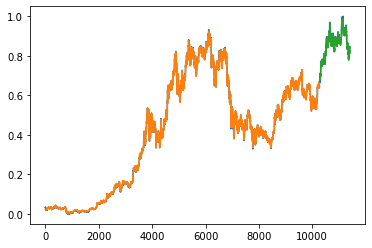

In [49]:
look_back=24
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [50]:
len(test_data)

1141

In [51]:
x_input=test_data[1117:].reshape(1,-1)
x_input.shape

(1, 24)

In [52]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [56]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=24
i=0
while(i<14):
    
    if(len(temp_input)>24):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

0 day input [0.7896589  0.78725266 0.78494054 0.7827186  0.78055012 0.77839935
 0.77626234 0.774158   0.77210575 0.7701124  0.76816797 0.76625335
 0.76435399 0.76246881 0.76060629 0.75877547 0.75698054 0.75522065
 0.75349391 0.75180107 0.75014722 0.7485382  0.74697888 0.745471  ]
0 day output [[0.74401414]]
1 day input [0.78725266 0.78494054 0.7827186  0.78055012 0.77839935 0.77626234
 0.774158   0.77210575 0.7701124  0.76816797 0.76625335 0.76435399
 0.76246881 0.76060629 0.75877547 0.75698054 0.75522065 0.75349391
 0.75180107 0.75014722 0.7485382  0.74697888 0.745471   0.74401414]
1 day output [[0.74260664]]
2 day input [0.78494054 0.7827186  0.78055012 0.77839935 0.77626234 0.774158
 0.77210575 0.7701124  0.76816797 0.76625335 0.76435399 0.76246881
 0.76060629 0.75877547 0.75698054 0.75522065 0.75349391 0.75180107
 0.75014722 0.7485382  0.74697888 0.745471   0.74401414 0.74260664]
2 day output [[0.7412479]]
3 day input [0.7827186  0.78055012 0.77839935 0.77626234 0.774158   0.772105

In [57]:
day_new=np.arange(1,25)
day_pred=np.arange(26,40)

In [58]:
len(df1)

11408

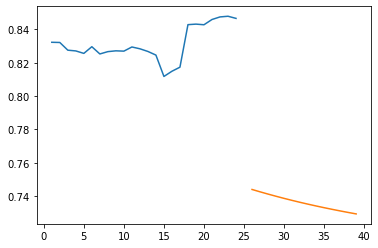

In [60]:
plt.plot(day_new,scaler.inverse_transform(df1[11384:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

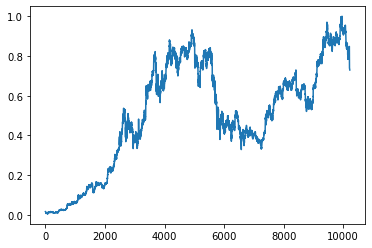

In [61]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [62]:
df3=scaler.inverse_transform(df3).tolist()

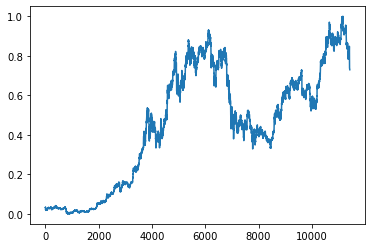

In [63]:
plt.plot(df3)